# Imports

In [1]:
import pandas as pd
import numpy as np
from numpy import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
from pandas.api.types import is_numeric_dtype


#  Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import KNNImputer


# Data Gathering

In [2]:
df = pd.read_csv("../Resources/healthcare-dataset-stroke-data.csv")  #,na_values='Unknown')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
smokers_grouped = df.groupby("smoking_status")["id"].count()
smokers_grouped.head(10)

smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
Name: id, dtype: int64

In [4]:
work_type_grouped = df.groupby("work_type")["id"].count()
work_type_grouped.head(10)

work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
Name: id, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Data Manipulation/Cleaning

In [6]:
# Delete 1 "other" gender
df = df.loc[df["gender"] != "Other"]

df.shape

(5109, 12)

In [7]:
# impute Nulls with mean/mode  
df.bmi.fillna(df.bmi.mean(), inplace=True)
    

C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [16]:
    # Substitute 1/0 for yes / no and rural / urban 

df["Sex_Label"] = [1 if x == "Male" else 0 for x in df.gender] #label encoding
df.drop("gender", axis=1, inplace=True)

df["Married_Label"] = [1 if x == "Yes" else 0 for x in df.ever_married] #label encoding
df.drop("ever_married", axis=1, inplace=True)

df["Residence_Label"] = [1 if x == "Rural" else 0 for x in df.Residence_type] #label encoding
df.drop("Residence_type", axis=1, inplace=True)
 

C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [17]:
df

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,Sex_Label,Married_Label,Residence_Label
0,9046,67.0,0,1,Private,228.69,36.60000,formerly smoked,1,1,1,0
1,51676,61.0,0,0,Self-employed,202.21,28.89456,never smoked,1,0,1,1
2,31112,80.0,0,1,Private,105.92,32.50000,never smoked,1,1,1,1
3,60182,49.0,0,0,Private,171.23,34.40000,smokes,1,0,1,0
4,1665,79.0,1,0,Self-employed,174.12,24.00000,never smoked,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,Private,83.75,28.89456,never smoked,0,0,1,0
5106,44873,81.0,0,0,Self-employed,125.20,40.00000,never smoked,0,0,1,0
5107,19723,35.0,0,0,Self-employed,82.99,30.60000,never smoked,0,0,1,1
5108,37544,51.0,0,0,Private,166.29,25.60000,formerly smoked,0,1,1,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   avg_glucose_level  5109 non-null   float64
 6   bmi                5109 non-null   float64
 7   smoking_status     5109 non-null   object 
 8   stroke             5109 non-null   int64  
 9   Sex_Label          5109 non-null   int64  
 10  Married_Label      5109 non-null   int64  
 11  Residence_Label    5109 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 518.9+ KB


In [19]:
#Split out work_type and smoking_status using get dummies
linear_dums = pd.get_dummies(df[["work_type", "smoking_status"]], drop_first=True) #linear models don't need the extra column
tree_dums = pd.get_dummies(df[["work_type", "smoking_status"]], drop_first=False)



In [20]:
linear_dums

,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0
2,0,1,0,0,0,1,0
3,0,1,0,0,0,0,1
4,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...
5105,0,1,0,0,0,1,0
5106,0,0,1,0,0,1,0
5107,0,0,1,0,0,1,0
5108,0,1,0,0,1,0,0


In [21]:
tree_dums

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,0,0,0,1,0
5106,0,0,0,1,0,0,0,1,0
5107,0,0,0,1,0,0,0,1,0
5108,0,0,1,0,0,0,1,0,0


In [22]:
# Combine back into the training set
df_train_linear = pd.concat([df[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke", "Sex_Label","Married_Label","Residence_Label"]], linear_dums], axis=1)
df_train_tree = pd.concat([df[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke", "Sex_Label","Married_Label","Residence_Label"]], tree_dums], axis=1)


In [23]:
# rename fields with bad syntax
df_train_linear = df_train_linear.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)
df_train_tree = df_train_tree.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)


In [24]:
df_train_linear

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,1,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,1,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,1,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,1,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,1,0,0,1,0,0


In [20]:
df_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   Sex_Label                       5109 non-null   int64  
 7   Married_Label                   5109 non-null   int64  
 8   Residence_Label                 5109 non-null   int64  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_self_employed         5109 non-null   uint8  
 12  work_type_children              51

In [25]:
df_train_linear

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,1,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,1,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,1,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,1,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,1,0,0,1,0,0


In [26]:
df_train_tree

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,0,1,0,0,0,1,0,0


In [27]:
df_train_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   Sex_Label                       5109 non-null   int64  
 7   Married_Label                   5109 non-null   int64  
 8   Residence_Label                 5109 non-null   int64  
 9   work_type_Govt_job              5109 non-null   uint8  
 10  work_type_Never_worked          5109 non-null   uint8  
 11  work_type_Private               5109 non-null   uint8  
 12  work_type_self_employed         51

## Data Cleanup / Scaling


In [28]:
#x_scaler = MinMaxScaler()


In [29]:
#features = df
#x_scaler.fit(features)

# Data Exploration

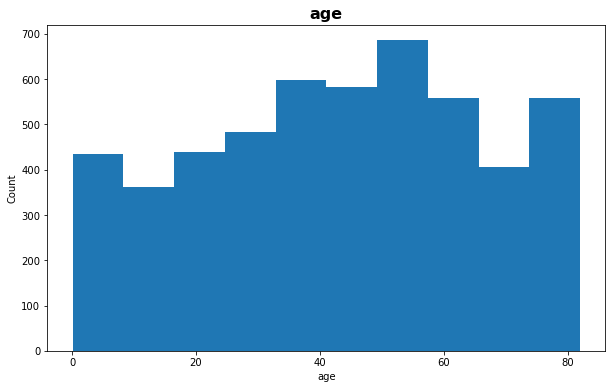

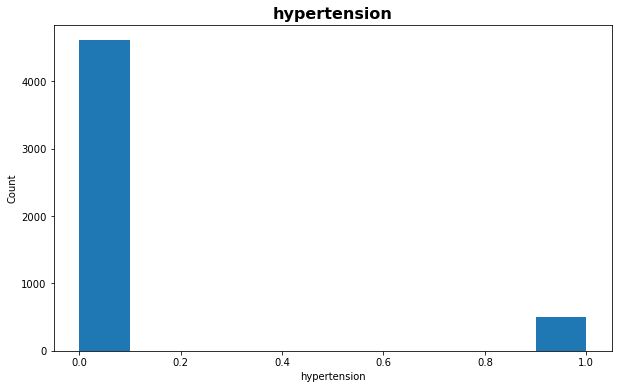

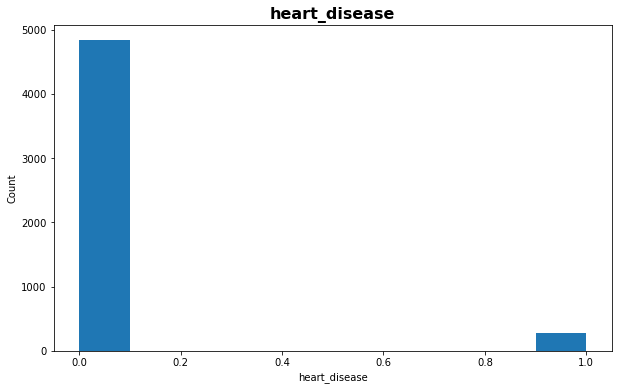

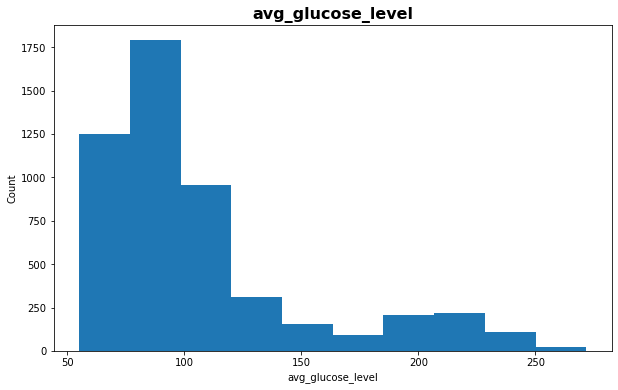

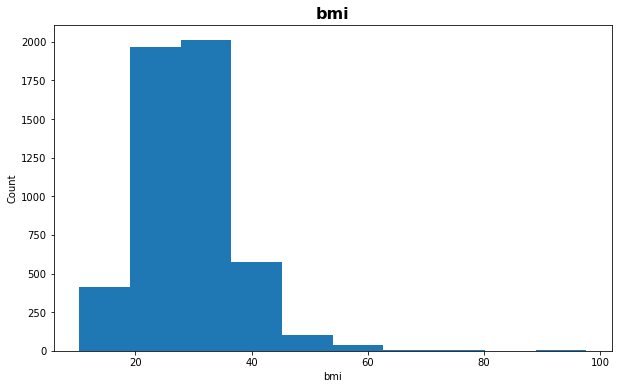

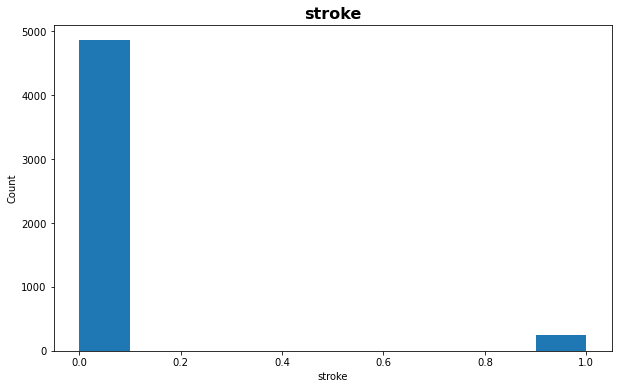

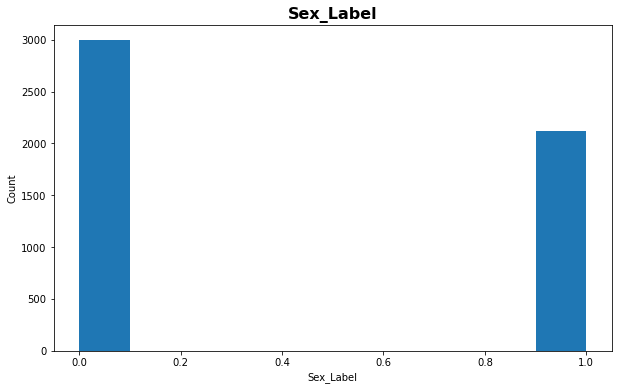

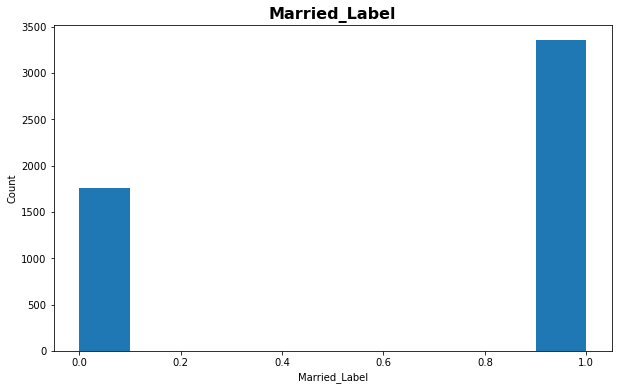

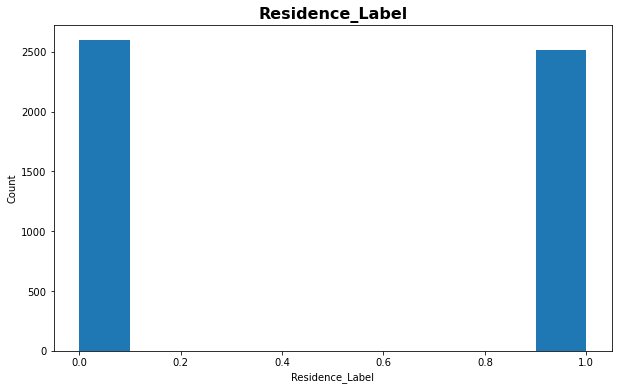

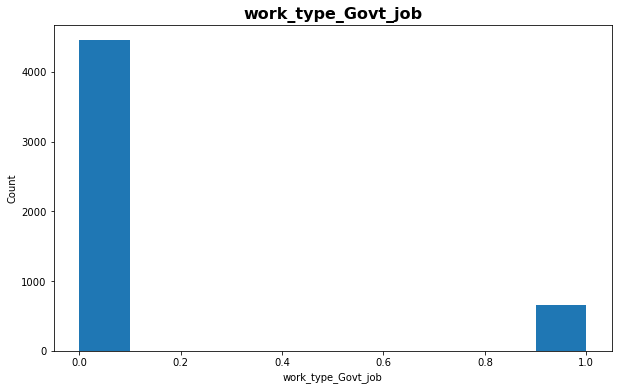

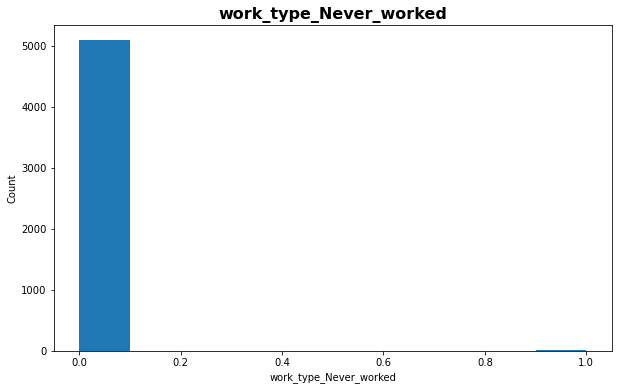

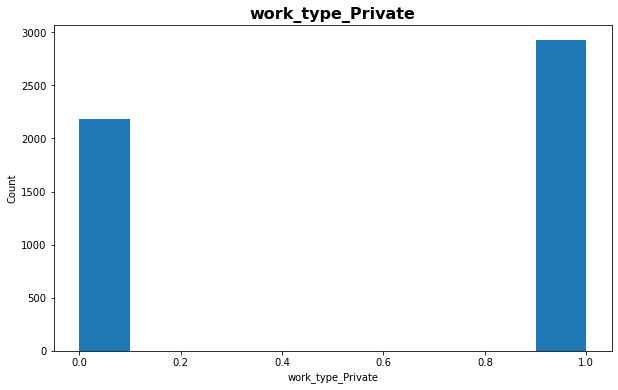

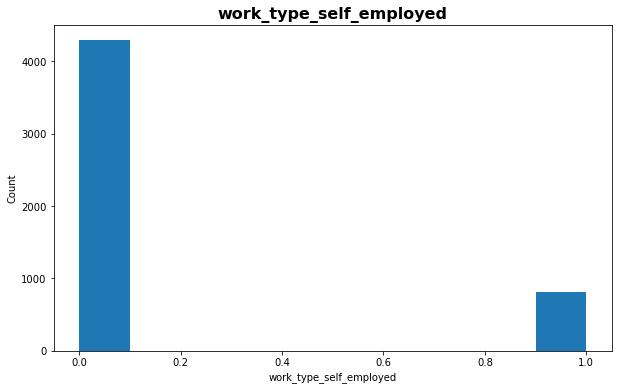

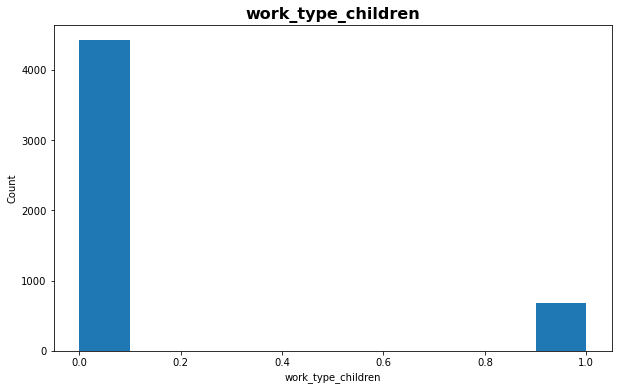

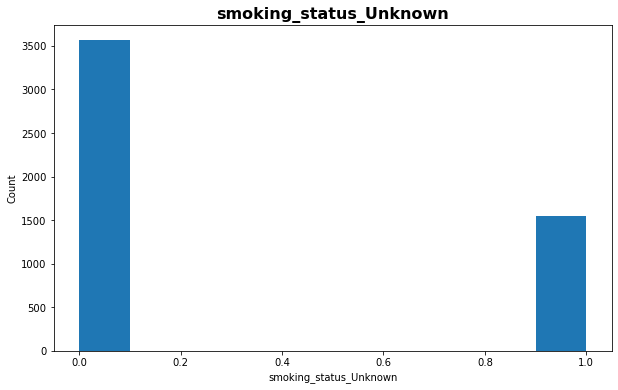

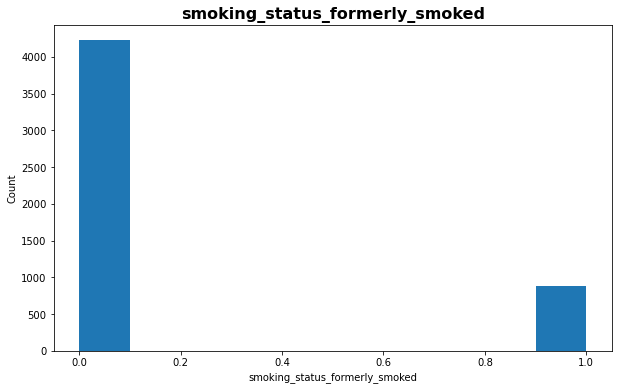

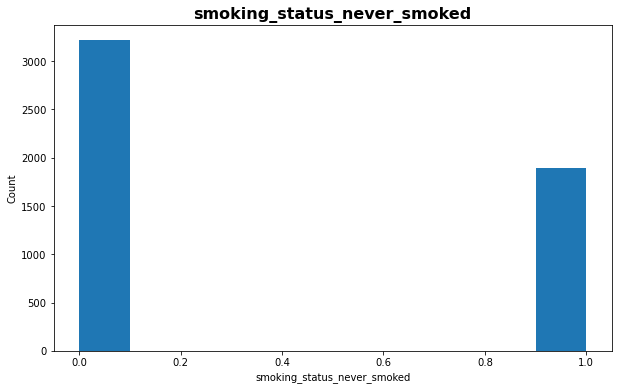

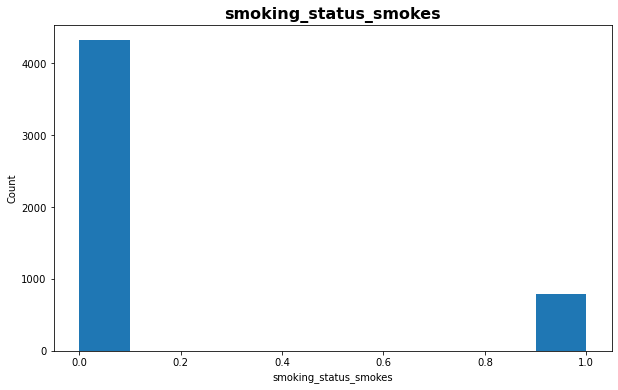

In [30]:
# Plot distributions
for col in df_train_tree.columns:
    
    plt.figure(figsize=(10,6))
    plt.hist(df_train_tree[col])
    plt.title(col, fontsize=16, fontweight="bold")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

## Correlations

In [31]:
df_train_tree.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
age,1.000000,0.276367,0.263777,0.238323,0.325861,0.245239,-0.027752,0.679084,-0.014031,0.129965,-0.078667,0.116678,0.327949,-0.634320,-0.378366,0.237347,0.119207,0.073075
hypertension,0.276367,1.000000,0.108292,0.174540,0.160151,0.127891,0.021223,0.164187,0.007980,0.017661,-0.021612,-0.005358,0.115417,-0.129535,-0.141551,0.059022,0.065018,0.031213
heart_disease,0.263777,0.108292,1.000000,0.161907,0.038865,0.134905,0.085685,0.114601,-0.003045,0.001312,-0.015715,0.000068,0.086742,-0.091654,-0.066765,0.066938,-0.021893,0.044030
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.168913,0.131991,0.054722,0.155329,0.004783,0.013908,-0.014665,0.016451,0.062770,-0.102195,-0.095035,0.067796,0.024011,0.017716
bmi,0.325861,0.160151,0.038865,0.168913,1.000000,0.038917,-0.025605,0.335564,0.000288,0.077885,-0.028613,0.204055,0.070757,-0.442946,-0.265094,0.104675,0.106105,0.085518
stroke,0.245239,0.127891,0.134905,0.131991,0.038917,1.000000,0.009081,0.108299,-0.015415,0.002660,-0.014885,0.011927,0.062150,-0.083888,-0.055924,0.064683,-0.004163,0.008920
Sex_Label,-0.027752,0.021223,0.085685,0.054722,-0.025605,0.009081,1.000000,-0.030171,0.006105,-0.016598,0.011486,-0.032502,-0.026045,0.089226,0.059557,0.043121,-0.098952,0.011408
Married_Label,0.679084,0.164187,0.114601,0.155329,0.335564,0.108299,-0.030171,1.000000,-0.005988,0.133964,-0.090873,0.154104,0.192637,-0.544658,-0.332335,0.171960,0.102663,0.105132
Residence_Label,-0.014031,0.007980,-0.003045,0.004783,0.000288,-0.015415,0.006105,-0.005988,1.000000,-0.013056,-0.022848,0.018005,-0.010508,0.002388,0.002167,-0.008093,0.024622,-0.027185
work_type_Govt_job,0.129965,0.017661,0.001312,0.013908,0.077885,0.002660,-0.016598,0.133964,-0.013056,1.000000,-0.025263,-0.444394,-0.167849,-0.151417,-0.097473,0.029865,0.046854,0.029994


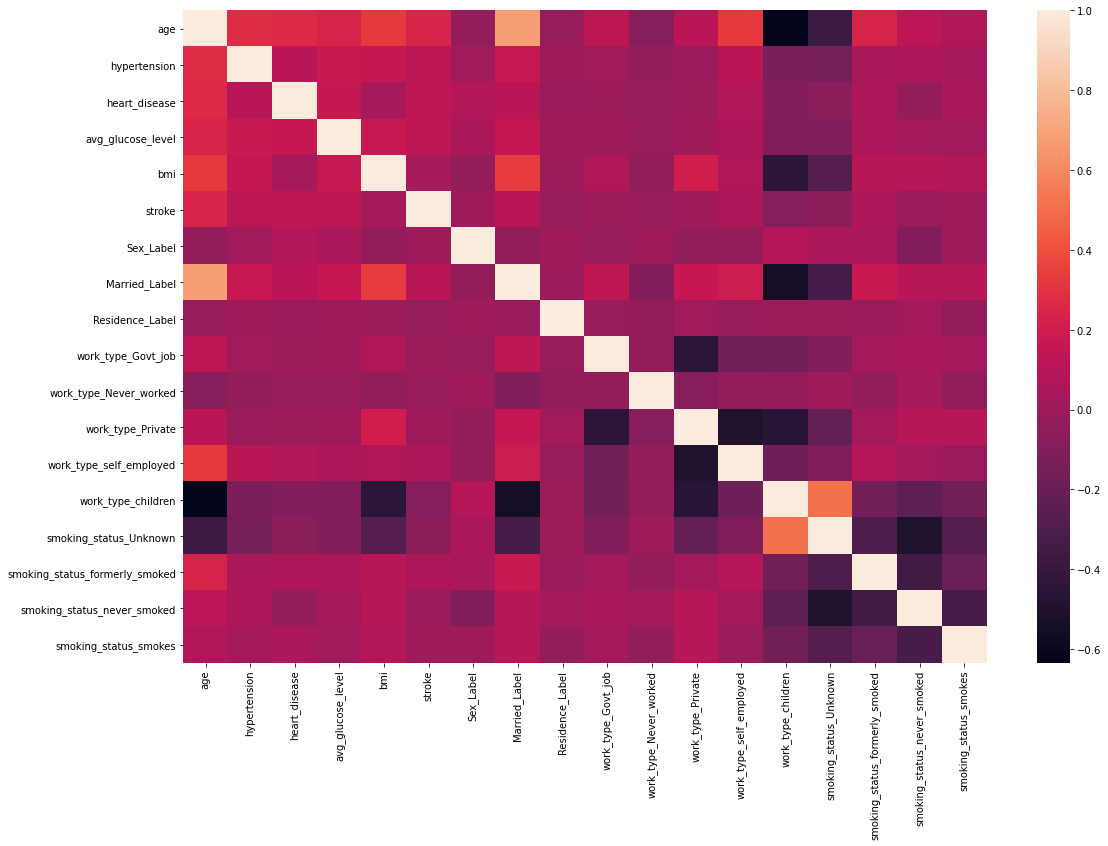

In [32]:
plt.figure(figsize=(18,12))
sns.heatmap(df_train_tree.corr())
plt.show()

# Machine Learning

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split

## Linear Models First

In [34]:
features = df_train_linear.drop("stroke", axis=1)
target = df_train_linear.stroke

In [35]:
X = features.to_numpy()
y = target.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3888
           1       0.00      0.00      0.00       199

    accuracy                           0.95      4087
   macro avg       0.48      0.50      0.49      4087
weighted avg       0.90      0.95      0.93      4087

In Sample Confusion Matrix: 
[[3888    0]
 [ 199    0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

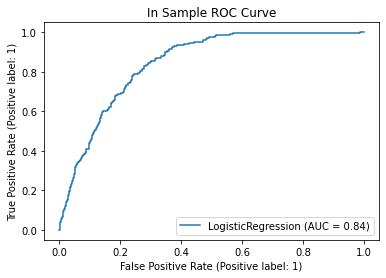


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[972   0]
 [ 49   1]]


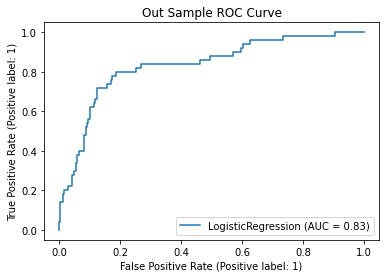

In [36]:
# initialize
log = LogisticRegression()

# fit
log = log.fit(X_train, y_train)

# predictions
in_preds = log.predict(X_train)
out_preds = log.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(log, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(log, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3888
           1       0.00      0.00      0.00       199

    accuracy                           0.95      4087
   macro avg       0.48      0.50      0.49      4087
weighted avg       0.90      0.95      0.93      4087

In Sample Confusion Matrix: 
[[3888    0]
 [ 199    0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


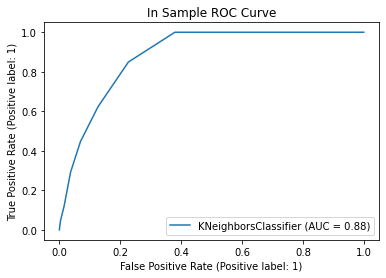


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[972   0]
 [ 50   0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


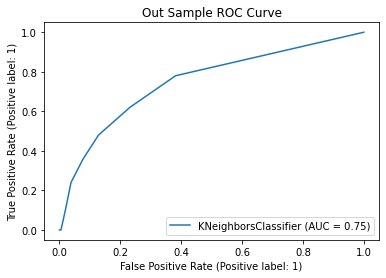

In [37]:
# initialize
knn = KNeighborsClassifier(n_neighbors=20)

# fit
knn = knn.fit(X_train, y_train)

# predictions
in_preds = knn.predict(X_train)
out_preds = knn.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(knn, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(knn, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3888
           1       0.00      0.00      0.00       199

    accuracy                           0.95      4087
   macro avg       0.48      0.50      0.49      4087
weighted avg       0.90      0.95      0.93      4087

In Sample Confusion Matrix: 
[[3888    0]
 [ 199    0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


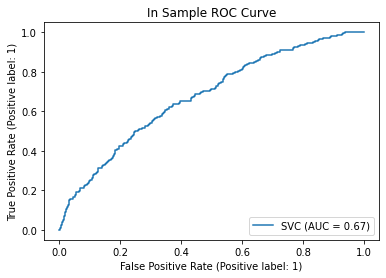


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[972   0]
 [ 50   0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


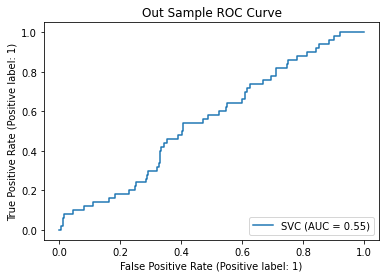

In [38]:
# initialize
svm = SVC()

# fit
svm = svm.fit(X_train, y_train)

# predictions
in_preds = svm.predict(X_train)
out_preds = svm.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(svm, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(svm, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

## Trees

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


In [40]:
features = df_train_tree.drop("stroke", axis=1)
target = df_train_tree.stroke

In [41]:
X = features.to_numpy()
y = target.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00       199

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087

In Sample Confusion Matrix: 
[[3888    0]
 [   0  199]]


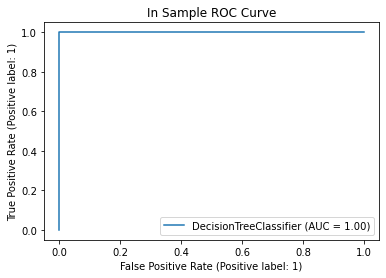


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.13      0.18      0.15        50

    accuracy                           0.90      1022
   macro avg       0.55      0.56      0.55      1022
weighted avg       0.92      0.90      0.91      1022

Out Sample Confusion Matrix: 
[[914  58]
 [ 41   9]]


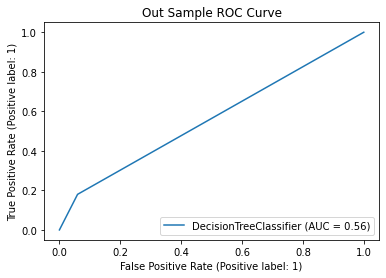

In [42]:
# initialize
dt = DecisionTreeClassifier()

# fit
dt = dt.fit(X_train, y_train)

# predictions
in_preds = dt.predict(X_train)
out_preds = dt.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(dt, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(dt, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00       199

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087

In Sample Confusion Matrix: 
[[3888    0]
 [   0  199]]


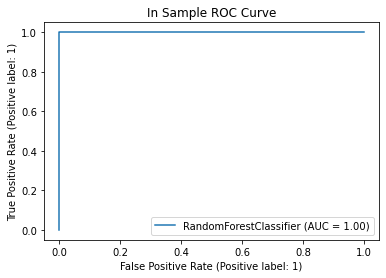


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[972   0]
 [ 50   0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


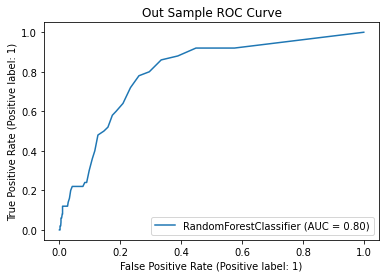

In [43]:
# initialize
rf = RandomForestClassifier()

# fit
rf = rf.fit(X_train, y_train)

# predictions
in_preds = rf.predict(X_train)
out_preds = rf.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(rf, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(rf, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3888
           1       0.43      0.02      0.03       199

    accuracy                           0.95      4087
   macro avg       0.69      0.51      0.50      4087
weighted avg       0.93      0.95      0.93      4087

In Sample Confusion Matrix: 
[[3884    4]
 [ 196    3]]


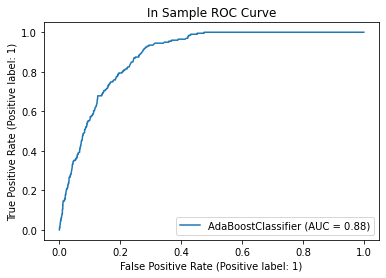


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.73      0.51      0.51      1022
weighted avg       0.93      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[971   1]
 [ 49   1]]


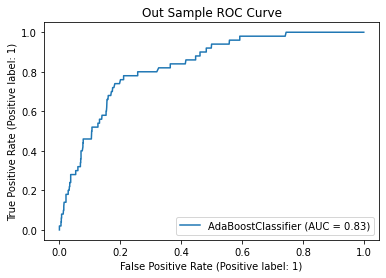

In [44]:
# initialize
ada = AdaBoostClassifier()

# fit
ada = ada.fit(X_train, y_train)

# predictions
in_preds = ada.predict(X_train)
out_preds = ada.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(ada, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(ada, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3888
           1       1.00      0.16      0.28       199

    accuracy                           0.96      4087
   macro avg       0.98      0.58      0.63      4087
weighted avg       0.96      0.96      0.94      4087

In Sample Confusion Matrix: 
[[3888    0]
 [ 167   32]]


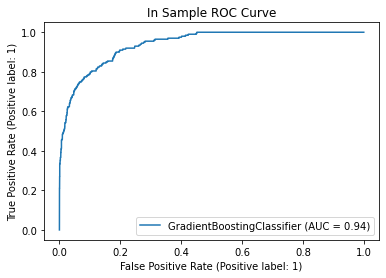


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[970   2]
 [ 49   1]]


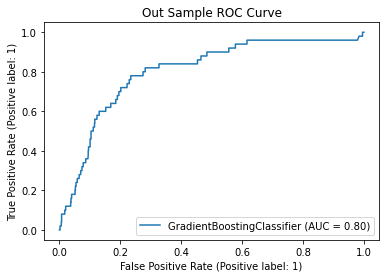

In [45]:
# initialize
gb = GradientBoostingClassifier()

# fit
gb = gb.fit(X_train, y_train)

# predictions
in_preds = gb.predict(X_train)
out_preds = gb.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(gb, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(gb, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

In [46]:
from xgboost import XGBClassifier

[20:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", "num_iterations" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3888
           1       1.00      0.09      0.17       199

    accuracy                           0.96      4087
   macro avg       0.98      0.55      0.57      4087
weighted avg       0.96      0.96      0.94      4087

In Sample Confusion Matrix: 
[[3888    0]
 [ 181   18]]


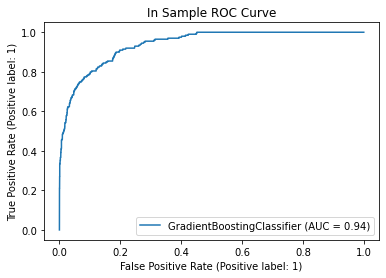


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Out Sample Confusion Matrix: 
[[972   0]
 [ 50   0]]


C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


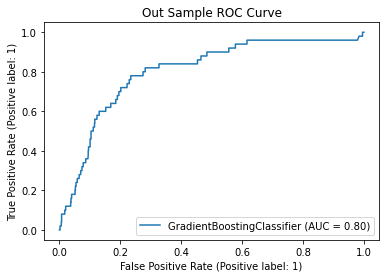

In [47]:
# initialize
xgb = XGBClassifier(use_label_encoder=False,eval_metric='error',learning_rate=0.03, num_iterations=1000, 
                              boosting='gbdt')


# fit
xgb = xgb.fit(X_train, y_train)

# predictions
in_preds = xgb.predict(X_train)
out_preds = xgb.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(gb, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(gb, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

# Model Selection

In [48]:
# We choose xgboost because of the high accuracy and F1 score in the stroke data analysis

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4860
           1       1.00      0.00      0.01       249

    accuracy                           0.95      5109
   macro avg       0.98      0.50      0.49      5109
weighted avg       0.95      0.95      0.93      5109

In Sample Confusion Matrix: 
[[4860    0]
 [ 248    1]]



C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


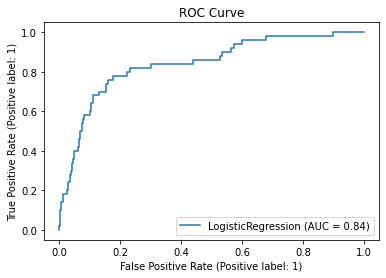

In [49]:
#initialize
log_final = LogisticRegression()



# fit
log_final.fit(X, y)

# predict
in_preds = log_final.predict(X)

#evaluate
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y, in_preds)}")
print()

# roc curve
plot_roc_curve(log_final, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Create Submission

In [68]:
# Read in data to predict
# from the 2nd cell above, don't have a test.csv, df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# df_test = pd.read_csv("test.csv")
df_test = pd.read_csv("../Resources/healthcare-dataset-stroke-data.csv")
df_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [70]:
# impute Nulls with mean/mode  
df_test.fillna(df.bmi.mean(), inplace=True)
    

In [71]:
#Save df_test to .csv to capture imputed BMI data for dashboards

df_test.to_csv('../Resources/healthcare-dataset-stroke-data_imputed_bmi.csv', index=False)

In [72]:
# manipulate columns 1
df_test.drop(["stroke"], axis=1, inplace=True) # drop stroke

# Delete 1 "other" gender
df_test = df_test.loc[df_test["gender"] != "Other"]

df_test.shape

(5109, 11)

In [73]:
# manipulate columns 2
    # Substitute 1/0 for yes / no and rural / urban 

df_test["Sex_Label"] = [1 if x == "Male" else 0 for x in df_test.gender] #label encoding
df_test.drop("gender", axis=1, inplace=True)

df_test["Married_Label"] = [1 if x == "Yes" else 0 for x in df_test.ever_married] #label encoding
df_test.drop("ever_married", axis=1, inplace=True)

df_test["Residence_Label"] = [1 if x == "Rural" else 0 for x in df_test.Residence_type] #label encoding
df_test.drop("Residence_type", axis=1, inplace=True)

In [74]:
df_test

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,Sex_Label,Married_Label,Residence_Label
0,9046,67.0,0,1,Private,228.69,36.60000,formerly smoked,1,1,0
1,51676,61.0,0,0,Self-employed,202.21,28.89456,never smoked,0,1,1
2,31112,80.0,0,1,Private,105.92,32.50000,never smoked,1,1,1
3,60182,49.0,0,0,Private,171.23,34.40000,smokes,0,1,0
4,1665,79.0,1,0,Self-employed,174.12,24.00000,never smoked,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,Private,83.75,28.89456,never smoked,0,1,0
5106,44873,81.0,0,0,Self-employed,125.20,40.00000,never smoked,0,1,0
5107,19723,35.0,0,0,Self-employed,82.99,30.60000,never smoked,0,1,1
5108,37544,51.0,0,0,Private,166.29,25.60000,formerly smoked,1,1,1


In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   avg_glucose_level  5109 non-null   float64
 6   bmi                5109 non-null   float64
 7   smoking_status     5109 non-null   object 
 8   Sex_Label          5109 non-null   int64  
 9   Married_Label      5109 non-null   int64  
 10  Residence_Label    5109 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 479.0+ KB


In [76]:
# Cast category to string - get dummies
tree_dums_test = pd.get_dummies(df_test[["work_type", "smoking_status"]], drop_first=False)
tree_dums_test

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,0,0,0,1,0
5106,0,0,0,1,0,0,0,1,0
5107,0,0,0,1,0,0,0,1,0
5108,0,0,1,0,0,0,1,0,0


In [77]:
# Combine back into the testing set
df_test_tree = pd.concat([df_test[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "Sex_Label","Married_Label","Residence_Label"]], tree_dums_test], axis=1)
df_test_tree

,age,hypertension,heart_disease,avg_glucose_level,bmi,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,1,1,1,0,0,1,0,0,0,1,0,0


## Final Data Cleanup

In [78]:
# convert work types from uint8 to integer
df_test_tree = df_test_tree.astype({"work_type_Govt_job": int, "work_type_Never_worked": int, "work_type_Private": int, "work_type_Self-employed": int, "work_type_children": int, "smoking_status_Unknown": int, "smoking_status_formerly smoked": int, "smoking_status_never smoked": int, "smoking_status_smokes": int})

In [79]:
# rename fields with bad syntax
df_test_tree = df_test_tree.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)

In [80]:
df_test_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   Sex_Label                       5109 non-null   int64  
 6   Married_Label                   5109 non-null   int64  
 7   Residence_Label                 5109 non-null   int64  
 8   work_type_Govt_job              5109 non-null   int32  
 9   work_type_Never_worked          5109 non-null   int32  
 10  work_type_Private               5109 non-null   int32  
 11  work_type_self_employed         5109 non-null   int32  
 12  work_type_children              51

In [81]:
# convert to list and then predict
X_test_data = df_test_tree.to_numpy()

# old command test_preds = xgb_final.predict(X_test_data)

test_preds = log_final.predict_proba(X_test_data)[:, 1]

#temporarily set threshold to max to see entire array
with np.printoptions(threshold=np.inf):
    print(test_preds)




[0.19399342 0.05185762 0.20806588 0.03969157 0.20018661 0.29446876
 0.17758807 0.13038536 0.04583192 0.16689692 0.2137584  0.07492187
 0.04438794 0.33674198 0.31306335 0.02959014 0.14491306 0.31655838
 0.06673429 0.12799656 0.15114503 0.04551827 0.20100742 0.35344251
 0.12895353 0.12392184 0.07775234 0.06616177 0.15215502 0.07930115
 0.10167651 0.01490837 0.28269395 0.32332653 0.02723743 0.41635013
 0.1989353  0.1522715  0.06232608 0.02108577 0.16238659 0.03087076
 0.3454335  0.07441001 0.12618698 0.26638724 0.20767775 0.05413247
 0.13875367 0.01508994 0.21584746 0.23181494 0.21752817 0.16296711
 0.08364622 0.12180407 0.15662843 0.29503779 0.16199515 0.06043098
 0.06358065 0.20551704 0.07747572 0.01945436 0.15898692 0.29691623
 0.1418     0.17553866 0.05528983 0.14650517 0.12207443 0.15903027
 0.10703819 0.09140919 0.02664728 0.17024433 0.36132181 0.21643725
 0.0369605  0.01456188 0.04513847 0.06518756 0.20476911 0.11044024
 0.04748582 0.03695913 0.08354344 0.11752779 0.023143   0.1489

In [82]:
final_sub = pd.DataFrame()
final_sub["id"] = df_test.id
final_sub["stroke"] = test_preds

In [83]:
final_sub

,id,stroke
0,9046,0.193993
1,51676,0.051858
2,31112,0.208066
3,60182,0.039692
4,1665,0.200187
...,...,...
5105,18234,0.228696
5106,44873,0.148741
5107,19723,0.005298
5108,37544,0.039817


In [84]:
final_sub.to_csv("submission.csv", index=False)

In [85]:
import pickle

In [87]:
# save model to disk
filename = '../finalized_model.sav'
pickle.dump(log_final, open(filename, 'wb'))

In [88]:
#my_new_model = pickle.load(filename)

# Feature importance

In [92]:
# Feature Importance - not for regression models
# feat_imps = pd.DataFrame(list(zip(features.columns, xgb_final.feature_importances_)), columns=["Feature", "Importance"])
# feat_imps_sort = feat_imps.sort_values(by="Importance", ascending=False).reset_index(drop=True)
# feat_imps_sort

In [93]:
# Plot Feature Importance -  - not for regression models
# plt.figure(figsize=(14,8))
# plt.bar(feat_imps_sort.Feature, feat_imps_sort.Importance)
# plt.title("Feature Importances")
# plt.xticks(rotation=45)
# plt.show()

## For After

In [94]:
new_pred = rf.predict_proba([X_test[0]])
new_pred

array([[0.99, 0.01]])

In [95]:
len(X[0])

17